<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/20_ABS_5_2_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%A1%D0%BB%D0%B5%D0%B4%D0%98%D0%B7%D0%BC%D0%93%D0%BB%D1%83%D0%B1%D0%A1%D0%B5%D1%82%D1%8C%D0%95%D0%B4%D0%9F%D1%80%D0%B5%D0%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогноз следующего изменения (глубокая сеть). Один первичный обработчик на все входы.**

**Абсолютный курс**

Енин А.В.

г. Оренбург

27.04.2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

## Альбом

https://photos.app.goo.gl/kKptHb2QPbNz1utSA

# Библиотеки

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [0]:
! wget -O abscur.py https://github.com/prog815/abscur_prediction/raw/master/abscur.py 
import abscur

--2020-05-03 06:34:31--  https://github.com/prog815/abscur_prediction/raw/master/abscur.py
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/prog815/abscur_prediction/master/abscur.py [following]
--2020-05-03 06:34:32--  https://raw.githubusercontent.com/prog815/abscur_prediction/master/abscur.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [text/plain]
Saving to: ‘abscur.py’

abscur.py           100%[===================>]   1.05K  --.-KB/s    in 0s      

2020-05-03 06:34:32 (31.8 MB/s) - ‘abscur.py’ saved [1078/1078]



In [0]:
import sys
if 'abscur' in sys.modules:
    del sys.modules['abscur']
import abscur

In [0]:
data = abscur.get_data()
d_data = data.pct_change()
d_data.shape

(1320, 45)

# Подготовка данных для модели

## Входы

In [0]:
Z = 30 # глубина линии задержки
(D,I) = d_data.shape
cur_names = list(data.columns)

inp = np.zeros((D,I,Z))

for i in range(I):
    for z in range(Z):
        inp[:,i,z] = d_data[cur_names[i]].shift(z+1).values

del D,I,Z

In [0]:
inp.shape

(1320, 45, 30)

## Выход

In [0]:
out_cur = np.random.choice(cur_names)
print('прогнозная валюта - ',out_cur)
out_name = 'out_' + out_cur
out = np.array(d_data[out_cur]>0,dtype=int)

прогнозная валюта -  nzd


## Чистим пустоты

In [0]:
ind_nan = np.isnan(inp.sum((1,2)))
inp = inp[~ind_nan]
out = out[~ind_nan]
del ind_nan

In [0]:
inp.shape,out.shape

((1289, 45, 30), (1289,))

## Разделяем выборки (индексами)

In [0]:
all_len = inp.shape[0]
train_len = int(all_len * 0.7)
test_len = all_len - train_len
ind_all = list(range(all_len))
ind_train = ind_all[:train_len]
ind_test = ind_all[train_len:]

## Нормировка и кодирование

In [0]:
X_train = inp[ind_train]
y_train = out[ind_train].reshape(-1,1)
X_test = inp[ind_test]
y_test = out[ind_test].reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

class DimScaler(StandardScaler):
    def fit(self,X):
        self.x_shape2 = X.shape[1:]
        super(DimScaler,self).fit(X.reshape(X.shape[0],-1))

    def transform(self,X):
        return super(DimScaler,self).transform(X.reshape(X.shape[0],-1)).reshape(X.shape[0],*(self.x_shape2))

ss = DimScaler()
ss.fit(X_train)
print(ss)

enc = OneHotEncoder(sparse=False)
enc.fit(y_train)
print(enc)

DimScaler(copy=True, with_mean=True, with_std=True)
OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)


# Сеть

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
from tensorflow import keras

# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc3


## Создание модели

In [0]:
class MLBlock(keras.layers.Layer):
    
    def __init__(self,obr):
        super(MLBlock,self).__init__()
        self.obr = obr

    def call(self,inputs):
        
        return keras.layers.concatenate(list([self.obr(inputs[:,i,:]) for i in range(inputs.shape[1])]))
        

In [0]:
regul = 1.0
dropout = 0.3
lr = 1e-2


obr = keras.Sequential()
obr.add(keras.layers.Dense(400,
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l2(regul)))
obr.add(keras.layers.Dropout(dropout))
obr.add(keras.layers.BatchNormalization())

obr.add(keras.layers.Dense(200,
                           activation='relu',
                           kernel_regularizer=keras.regularizers.l2(regul)))
obr.add(keras.layers.Dropout(dropout))
obr.add(keras.layers.BatchNormalization())

pred_obr = MLBlock(obr)

model = keras.Sequential()

model.add(pred_obr)

model.add(keras.layers.Dense(400,
                             activation='relu',
                             kernel_regularizer=keras.regularizers.l2(regul)))
model.add(keras.layers.Dropout(dropout))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2,activation='softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


## Обучение

In [0]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=100,
                                            mode='max',
                                            restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau()

hist = model.fit(ss.transform(X_train),
                 enc.transform(y_train),
                 validation_split=0.2,
                 epochs=300,
                 callbacks=[es_callback,reduce_lr],
                 batch_size=128)

print(model.summary())

print(model.evaluate(ss.transform(X_test),enc.transform(y_test)))

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

6/6 [==============================] - 2s 324ms/step - loss: 453.3633 - accuracy: 0.5062 - val_loss: 237.0836 - val_accuracy: 0.5028 - lr: 0.0100
Epoch 2/300
6/6 [==============================] - 0s 51ms/step - loss: 129.7719 - accuracy: 0.5589 - val_loss: 110.6438 - val_accuracy: 0.4862 - lr: 0.0100
Epoch 3/300
6/6 [==============================] - 0s 54ms/step - loss: 100.1612 - accuracy: 0.5201 - val_loss: 66.2270 - val_accuracy: 0.5083 - lr: 0.0100
Epoch 4/300
6/6 [====================

## Графики обучения

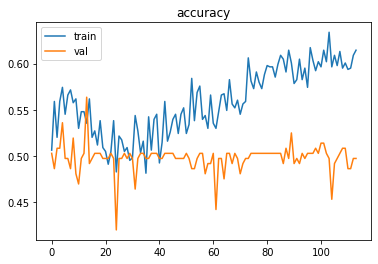

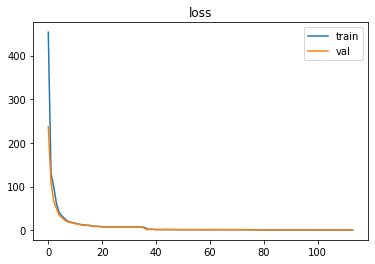

In [0]:
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='val')
plt.title('loss')
plt.legend()
plt.show()

# Расчет по модели

In [0]:
pred_train = enc.inverse_transform(model.predict(ss.transform(X_train)))
pred_test = enc.inverse_transform(model.predict(ss.transform(X_test)))

# Результаты эксперимента

In [0]:
from sklearn.metrics import *

print('----------- train report -----------')
print(classification_report(y_train,pred_train))

print('----------- test report -----------')
print(classification_report(y_test,pred_test))

----------- train report -----------
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       464
           1       0.55      0.61      0.58       438

    accuracy                           0.56       902
   macro avg       0.57      0.57      0.56       902
weighted avg       0.57      0.56      0.56       902

----------- test report -----------
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       202
           1       0.44      0.56      0.50       185

    accuracy                           0.45       387
   macro avg       0.46      0.46      0.45       387
weighted avg       0.46      0.45      0.45       387

